In [1]:
import shapely.geometry as geo
import geopandas as gpd
import pandas as pd
from pyproj import Proj, transform
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
warnings.filterwarnings(action='ignore') 

In [2]:
city = 'seoul'

In [3]:
def make_point(coor_list):
    point_list = []
    for i in range(len(coor_list)):
        coor = coor_list[i]
        point = geo.Point(coor)
        point_list.append(point)
    
    return point_list

In [4]:
with open(f'../data/{city}/2019_dict', 'rb') as f:
    cen_b = pickle.load(f, encoding='utf-8') 
    cen_b = cen_b.sort_index().reset_index()
    cen_b.rename(columns = {'index':'ID'}, inplace=True)
with open(f'../data/{city}/frame_dict', 'rb') as f:
    cen_a = pickle.load(f, encoding='utf-8') 
    
for _ in range(9):
    cen_a[_] = cen_a[_].sort_index().reset_index()
    cen_a[_].rename(columns = {'index':'ID'}, inplace=True)
    cen_a[_] = cen_a[_][cen_a[_]['ID'] != 2386] # 서울 19년도에 운영 안된 ,,
    
# cen_b['ID'].to_csv(f'../data/{city}/all_sta_id.csv',index=None)

In [5]:
if city == 'seoul':
    con_sta_info = pd.read_csv('../data/seoul/대여소정보_20220803.csv')
    city_map = gpd.read_file('../data/seoul/_census_data_2020_bnd_sigungu_bnd_sigungu_11_2020_2020/bnd_sigungu_11_2020_2020_2Q.shp', encoding = 'cp949')
elif city == 'daejeon':
    con_sta_info = pd.read_csv('../data/daejeon/타슈 대여소정보_220601v2.csv')
    city_map = gpd.read_file('..data/daejeon/_census_data_2021_bnd_sigungu_bnd_sigungu_25_2021_2021\bnd_sigungu_25_2021_2021_2Q.shp', encoding = 'cp949')
con_sta_info = con_sta_info[['ID','Xn','Yn']]
con_sta_info = con_sta_info[con_sta_info['ID'].isin(cen_b['ID'])].sort_values('ID')
con_sta_info['geometry'] = make_point(con_sta_info[['Xn','Yn']].values.tolist())
con_sta_info = con_sta_info[['ID','geometry']]

2019년 대비 pandemic 구간의 중심성 증감률 비교  
$\frac{x_{new}-x_{old}}{x_{old}}$

In [6]:
cen_error = {}
for _ in range(9):
    df_error = pd.merge(cen_a[_],cen_b,how='outer',on='ID')
    df_error = pd.merge(df_error,con_sta_info,how='outer',on='ID')
    df_error.fillna(0,inplace=True) # 특정 구간에 이용 안된 것 0으로 채움
    df_error = pd.DataFrame({'ID':df_error['ID'],'deg':df_error['weighted_deg_x']-df_error['weighted_deg_y'],
                             'clo':df_error['closeness_cent_x']-df_error['closeness_cent_y'],
                             'bet':df_error['betweeness_cent_x']-df_error['betweeness_cent_y'],
                             'pag':df_error['pagerank_x']-df_error['pagerank_y'],
                             'geometry' : df_error['geometry']
                            })
    cen_error[_] = gpd.GeoDataFrame(df_error, geometry = 'geometry')


In [7]:
cen_error[0].head()

,ID,deg,clo,bet,pag,geometry
0,102,-0.609417,-0.001469,0.000231,-0.000096,POINT (947943.924 1950863.373)
1,103,-0.395491,-0.001449,0.000022,0.000008,POINT (947961.634 1950785.809)
2,104,-0.306517,-0.001472,0.000151,0.000032,POINT (948325.239 1950304.009)
3,105,-0.153038,-0.001394,0.000262,0.000077,POINT (948310.657 1950235.113)
4,106,-0.427602,-0.001500,0.000987,0.000624,POINT (948133.146 1950085.123)


---
### 시각화

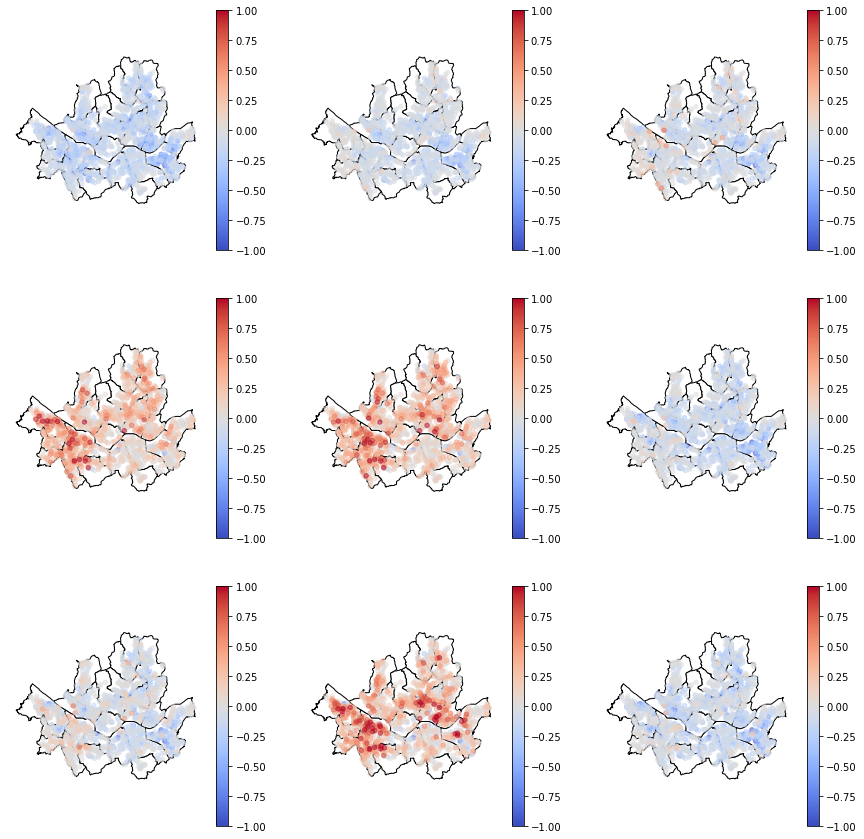

In [16]:
fig, ax = plt.subplots(
    nrows=3, ncols=3, 
    gridspec_kw={'hspace': 0.2, 'wspace': 0.2},sharex=True,sharey=True,figsize=(15,15))

#가로로 0 1 2/ 3 4 5/ 6 7 8
for x,y,i in zip([0,0,0,1,1,1,2,2,2],[0,1,2,0,1,2,0,1,2],np.arange(9)):
    city_map.plot(ax=ax[x][y],color='white', edgecolor = 'black')
    ax[x][y].axis('off')
    ax1 = cen_error[i].sort_values(by='deg',ascending=False).sort_values(by='deg').plot(ax = ax[x][y]
                                                        ,column='deg',cmap='coolwarm',legend=True,markersize = 20,alpha=0.5
                                                        ,vmin = -1, vmax = 1 # 서울
#                                                         ,vmin = -0.4, vmax = 0.4 # 대전
                                                                            )



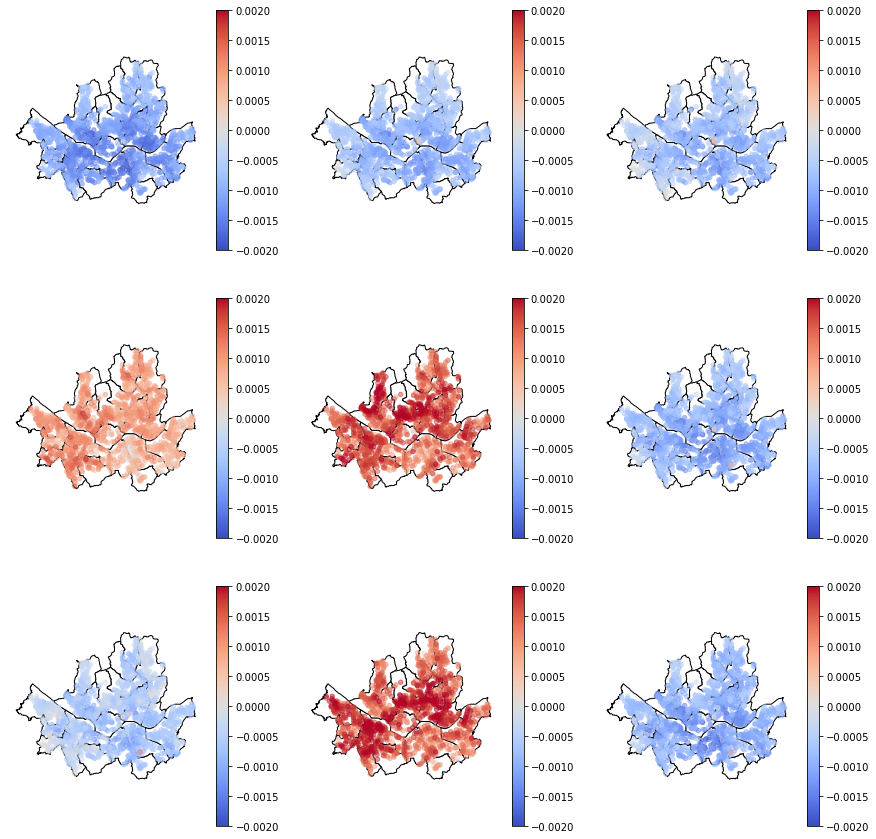

In [10]:
fig, ax = plt.subplots(
    nrows=3, ncols=3, 
    gridspec_kw={'hspace': 0.2, 'wspace': 0.2},sharex=True,sharey=True,figsize=(15,15))

#가로로 0 1 2/ 3 4 5/ 6 7 8
for x,y,i in zip([0,0,0,1,1,1,2,2,2],[0,1,2,0,1,2,0,1,2],np.arange(9)):
    city_map.plot(ax=ax[x][y],color='white', edgecolor = 'black')
    ax[x][y].axis('off')
    ax1 = cen_error[i].sort_values(by='clo',ascending=False).sort_values(by='clo').plot(ax = ax[x][y]
                                                        ,
                                                                                        column='clo',cmap='coolwarm',legend=True,markersize = 20,alpha=0.5
                                                        ,vmin = -0.002, vmax = 0.002 # 서울
#                                                         ,vmin = -0.002, vmax = 0.002 # 대전
                                                                            )



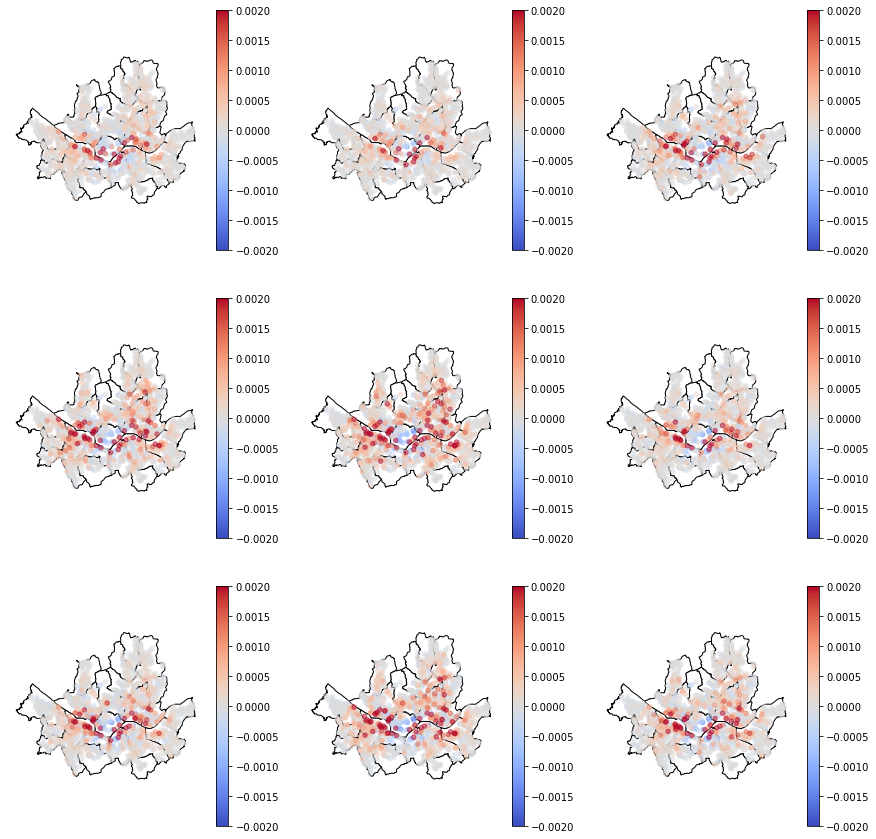

In [25]:
fig, ax = plt.subplots(
    nrows=3, ncols=3, 
    gridspec_kw={'hspace': 0.2, 'wspace': 0.2},sharex=True,sharey=True,figsize=(15,15))

#가로로 0 1 2/ 3 4 5/ 6 7 8
for x,y,i in zip([0,0,0,1,1,1,2,2,2],[0,1,2,0,1,2,0,1,2],np.arange(9)):
    city_map.plot(ax=ax[x][y],color='white', edgecolor = 'black')
    ax[x][y].axis('off')
    ax1 = cen_error[i].sort_values(by='bet',ascending=False).sort_values(by='bet').plot(ax = ax[x][y]
                                                        ,column='bet',cmap='coolwarm',legend=True,markersize = 20,alpha=0.5
                                                        ,vmin = -0.002, vmax = 0.002 # 서울
#                                                         ,vmin = -0.002, vmax = 0.002 # 대전
                                                                            )



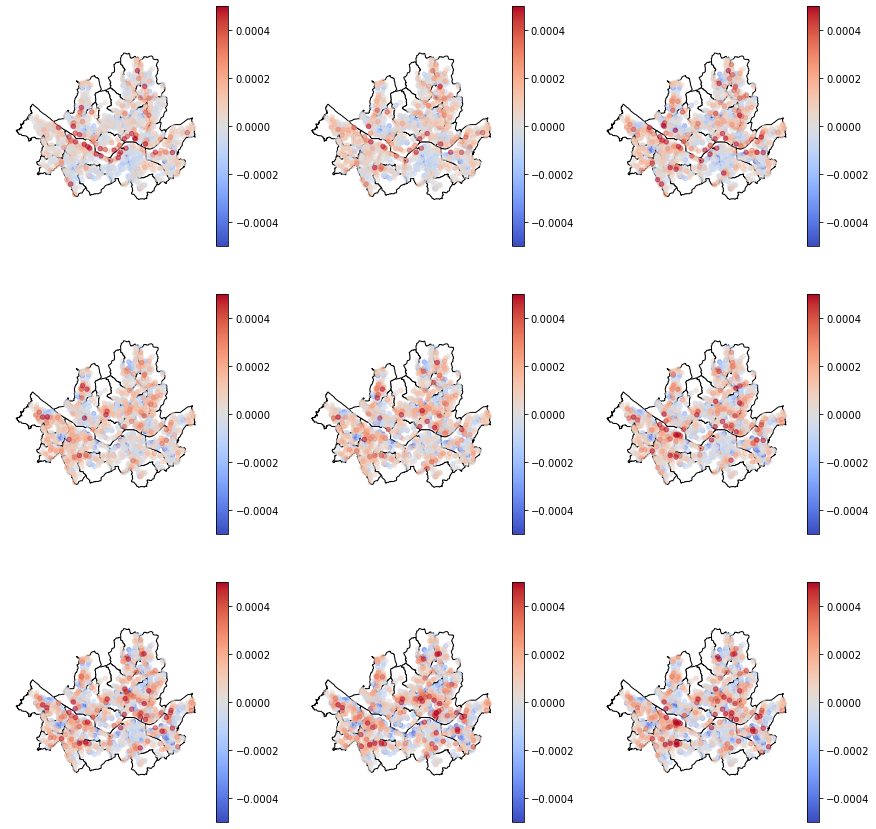

In [30]:
fig, ax = plt.subplots(
    nrows=3, ncols=3, 
    gridspec_kw={'hspace': 0.2, 'wspace': 0.2},sharex=True,sharey=True,figsize=(15,15))

#가로로 0 1 2/ 3 4 5/ 6 7 8
for x,y,i in zip([0,0,0,1,1,1,2,2,2],[0,1,2,0,1,2,0,1,2],np.arange(9)):
    city_map.plot(ax=ax[x][y],color='white', edgecolor = 'black')
    ax[x][y].axis('off')
    ax1 = cen_error[i].sort_values(by='pag',ascending=False).sort_values(by='pag').plot(ax = ax[x][y]
                                                        ,column='pag',cmap='coolwarm',legend=True,markersize = 20,alpha=0.5
                                                        ,vmin = -0.0005, vmax = 0.0005 # 서울
#                                                         ,vmin = -0.002, vmax = 0.002 # 대전
                                                                            )


